# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.columns = data.columns.str.lower()
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


                   registrationyear     power  kilometer  registrationmonth  \
registrationyear           1.000000 -0.000828  -0.053447          -0.011619   
power                     -0.000828  1.000000   0.024002           0.043380   
kilometer                 -0.053447  0.024002   1.000000           0.009571   
registrationmonth         -0.011619  0.043380   0.009571           1.000000   
postalcode                -0.003459  0.021665  -0.007698           0.013995   

                   postalcode  
registrationyear    -0.003459  
power                0.021665  
kilometer           -0.007698  
registrationmonth    0.013995  
postalcode           1.000000  


<AxesSubplot:>

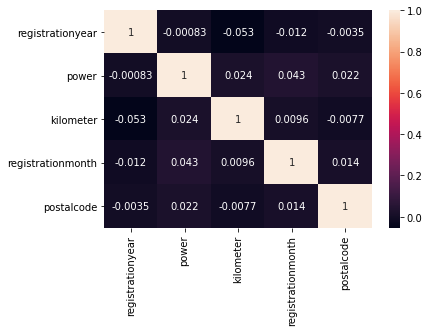

In [5]:
# посмотрим матрицу корреляции для выявления зависимости
# между числовыми данными
numeric_col = ['registrationyear','power','kilometer','registrationmonth','postalcode']

corr_matrix = data.loc[:,numeric_col].corr()
print(corr_matrix)

sn.heatmap(corr_matrix, annot=True)

Достаточной корреляции между признаками не обнаружено, нет проблем для предобработки данных.

Столбцы `datecrawled`, `datecreated`, `numberofpictures`, `postalcode`, `lastseen` будут удалены, так как полезной информации для исследования они не предоставляют и могут вызывать лишние зависимости.

In [6]:
# удаление столбцов для исключения выявления лишней зависимости
data = data.drop(['datecrawled','datecreated','numberofpictures','postalcode','lastseen'], axis=1)
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [7]:
# проверка на наличие строк-дубликатов
data.duplicated().sum()

27543

In [8]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              326826 non-null  int64 
 1   vehicletype        291577 non-null  object
 2   registrationyear   326826 non-null  int64 
 3   gearbox            309248 non-null  object
 4   power              326826 non-null  int64 
 5   model              308294 non-null  object
 6   kilometer          326826 non-null  int64 
 7   registrationmonth  326826 non-null  int64 
 8   fueltype           295704 non-null  object
 9   brand              326826 non-null  object
 10  repaired           260399 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


#### Вывод

- заголовки датафрейма приведены к нижнему регистру
- построена матрица корреляции для выявления зависимости между числовыми данными, достаточной корреляции между признаками не обнаружено
- удалены неинформативные столбцы
- удалены строки дубликаты

### Обработка пропусков 

In [10]:
# расчёт доли пропусков 
data.isna().mean()

price                0.000000
vehicletype          0.107852
registrationyear     0.000000
gearbox              0.053784
power                0.000000
model                0.056703
kilometer            0.000000
registrationmonth    0.000000
fueltype             0.095225
brand                0.000000
repaired             0.203249
dtype: float64

In [11]:
data['vehicletype'].value_counts()

sedan          83602
small          73496
wagon          59662
bus            26795
convertible    18752
coupe          15120
suv            10977
other           3173
Name: vehicletype, dtype: int64

In [12]:
data['vehicletype'] = data['vehicletype'].fillna(value = 'unknown')
data['vehicletype'].value_counts()

sedan          83602
small          73496
wagon          59662
unknown        35249
bus            26795
convertible    18752
coupe          15120
suv            10977
other           3173
Name: vehicletype, dtype: int64

In [13]:
data['gearbox'].value_counts()

manual    248135
auto       61113
Name: gearbox, dtype: int64

In [14]:
data['gearbox'] = data['gearbox'].fillna(value = 'unknown')
data['gearbox'].value_counts()

manual     248135
auto        61113
unknown     17578
Name: gearbox, dtype: int64

In [15]:
data['model'].value_counts()

golf                  26444
other                 23231
3er                   18037
polo                  11934
corsa                 11381
                      ...  
kalina                    8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

In [16]:
data['model'] = data['model'].fillna(value = 'unknown')
data['model'].value_counts()

golf                  26444
other                 23231
unknown               18532
3er                   18037
polo                  11934
                      ...  
kalina                    8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 251, dtype: int64

In [17]:
data['fueltype'].value_counts()

petrol      200260
gasoline     89464
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: fueltype, dtype: int64

In [18]:
data['fueltype'] = data['fueltype'].fillna(value = 'unknown')
data['fueltype'].value_counts()

petrol      200260
gasoline     89464
unknown      31122
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: fueltype, dtype: int64

In [19]:
data['repaired'].value_counts()

no     225970
yes     34429
Name: repaired, dtype: int64

In [20]:
data['repaired'] = data['repaired'].fillna(value = 'unknown')
data['repaired'].value_counts()

no         225970
unknown     66427
yes         34429
Name: repaired, dtype: int64

#### Вывод

Пропуски в столбцах заполнены значением `unknown`.

### Обработка аномалий

In [21]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Text(0.5, 0, 'Год')

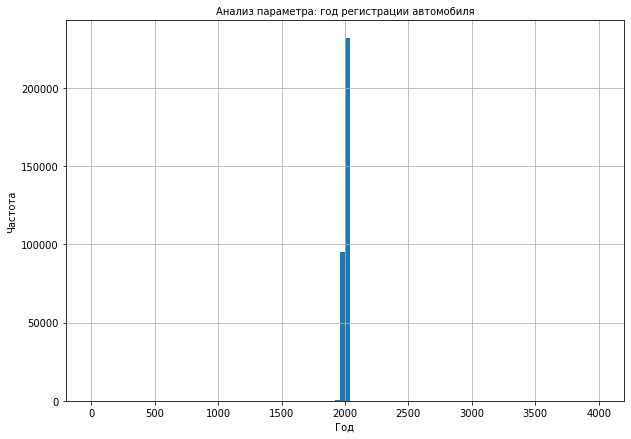

In [22]:
data['registrationyear'].hist(bins=100, range = (0, 4000), figsize = (10, 7))
plt.title('Анализ параметра: год регистрации автомобиля', fontsize=10)
plt.ylabel('Частота', fontsize=10)
plt.xlabel('Год', fontsize=10)

Text(0.5, 0, 'Мощность')

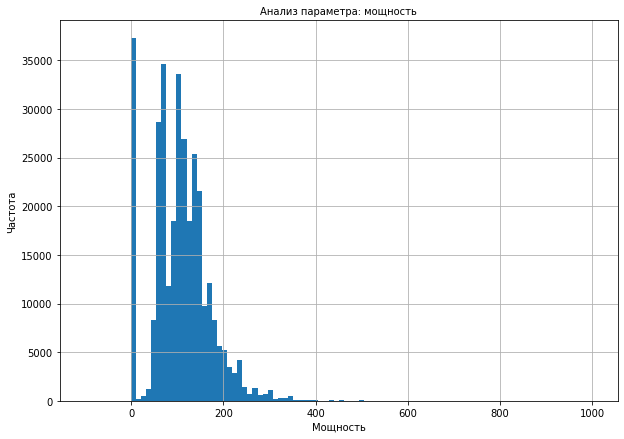

In [23]:
data['power'].hist(bins=100, range = (-100, 1000), figsize = (10, 7))
plt.title('Анализ параметра: мощность', fontsize=10)
plt.ylabel('Частота', fontsize=10)
plt.xlabel('Мощность', fontsize=10)

In [24]:
power_median = int(data['power'].median())
data['power'] = data['power'].replace(0, power_median)

Text(0.5, 0, 'Месяц')

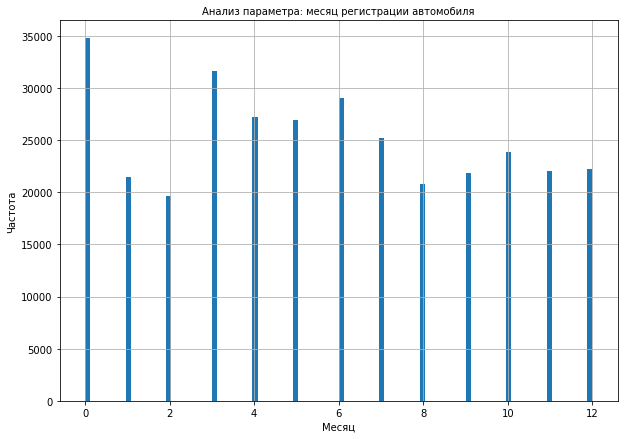

In [25]:
data['registrationmonth'].hist(bins=100, figsize = (10, 7))
plt.title('Анализ параметра: месяц регистрации автомобиля', fontsize=10)
plt.ylabel('Частота', fontsize=10)
plt.xlabel('Месяц', fontsize=10)

In [26]:
data['registrationmonth'] = data['registrationmonth'].replace(0, 10)

#### Вывод

Аномалии:
- в столбце `power` заменены на медианное значение
- в столбце `registrationmonth` заменены на предполагаемое значение

In [27]:
data_1 = data.copy(deep=True)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              326826 non-null  int64 
 1   vehicletype        326826 non-null  object
 2   registrationyear   326826 non-null  int64 
 3   gearbox            326826 non-null  object
 4   power              326826 non-null  int64 
 5   model              326826 non-null  object
 6   kilometer          326826 non-null  int64 
 7   registrationmonth  326826 non-null  int64 
 8   fueltype           326826 non-null  object
 9   brand              326826 non-null  object
 10  repaired           326826 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


In [28]:
data_ohe = pd.get_dummies(data_1, drop_first=True)

### Кодирование метки

In [29]:
# замена типа object на тип category
data['vehicletype'] = data['vehicletype'].astype('category')
data['gearbox'] = data['gearbox'].astype('category')
data['model'] = data['model'].astype('category')
data['fueltype'] = data['fueltype'].astype('category')
data['brand'] = data['brand'].astype('category')
data['repaired'] = data['repaired'].astype('category')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              326826 non-null  int64   
 1   vehicletype        326826 non-null  category
 2   registrationyear   326826 non-null  int64   
 3   gearbox            326826 non-null  category
 4   power              326826 non-null  int64   
 5   model              326826 non-null  category
 6   kilometer          326826 non-null  int64   
 7   registrationmonth  326826 non-null  int64   
 8   fueltype           326826 non-null  category
 9   brand              326826 non-null  category
 10  repaired           326826 non-null  category
dtypes: category(6), int64(5)
memory usage: 14.7 MB


## Обучение моделей

### Разбиение на выборки

In [31]:
# определение целевого признака и признаков 
target = data['price']
features = data.drop('price', axis=1)

target_1 = data_ohe['price']
features_1 = data_ohe.drop('price', axis=1)

In [32]:
# деление исходного набора данных на две выборки: обучающую и тестовую
# под обучающую отвела 60%, под тестовую - 40%, чтобы в дальнейшем разбить 
# её на тестовую и валидационную
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.4,
                                                                            random_state=12345)
# деление тестовой выборки на тестовую и валидационную
# от исходного набора данных они содержат каждая по 20%
features_test, features_valid, target_test, target_valid = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size = 0.5, 
                                                                            random_state=12345)

In [33]:
features_train_1, features_test_1, target_train_1, target_test_1 = train_test_split(features_1, 
                                                                                    target_1, 
                                                                                    test_size = 0.4,
                                                                                    random_state=12345)

features_test_1, features_valid_1, target_test_1, target_valid_1 = train_test_split(features_test_1, 
                                                                                    target_test_1, 
                                                                                    test_size = 0.5, 
                                                                                    random_state=12345)

In [34]:
# проверка корректности разбиения
print(features_train.shape,
      features_test.shape, 
      features_valid.shape)

(196095, 10) (65365, 10) (65366, 10)


### Обучение моделей

In [35]:
best_model_forest = None
best_result_forest = 2500
best_est_forest = 0
best_depth_forest = 0 

for est in range(10,31,5):
    for depth in range(1,8):
        model_forest = RandomForestRegressor(random_state = 12345,
                                             n_estimators = est, 
                                             max_depth = depth)
        model_forest.fit(features_train_1, target_train_1)
        pred_valid_forest = model_forest.predict(features_valid_1)
        rmse_forest = mean_squared_error(target_valid_1, pred_valid_forest)**0.5
        
        if rmse_forest < best_result_forest:
            best_model_forest = model_forest
            best_result_forest = rmse_forest
            best_est_forest = est
            best_depth_forest = depth

print('Лучшее значение RSME:', best_result_forest, 
      'Количество деревьев:', best_est_forest,
      'Глубина дерева:', best_depth_forest)

Лучшее значение RSME: 2262.361493705918 Количество деревьев: 30 Глубина дерева: 7


In [36]:
best_model_catboost = None
best_result_catboost = 2500
best_depth = 0 

for depth in range(1,5):
    model_catboost = CatBoostRegressor(max_depth = depth)
    category = ['vehicletype','gearbox','model','fueltype','brand','repaired']
    model_catboost.fit(features_train, target_train, cat_features=category, verbose=100)
    pred_valid_catboost = model_catboost.predict(features_valid)
    rmse_catboost = mean_squared_error(target_valid, pred_valid_catboost)**0.5
        
    if rmse_catboost < best_result_catboost:
        best_model_catboost = model_catboost
        best_result_catboost = rmse_catboost
        best_depth = depth
        
print('Лучшее значение RSME:', best_result_catboost,
      'Глубина дерева:', best_depth)

Learning rate set to 0.094273
0:	learn: 4395.0438446	total: 92.2ms	remaining: 1m 32s
100:	learn: 2572.7035777	total: 2.63s	remaining: 23.5s
200:	learn: 2386.2714764	total: 5.22s	remaining: 20.8s
300:	learn: 2331.8632481	total: 7.69s	remaining: 17.9s
400:	learn: 2307.9079677	total: 10.3s	remaining: 15.3s
500:	learn: 2295.8259378	total: 12.8s	remaining: 12.8s
600:	learn: 2287.7525609	total: 15.5s	remaining: 10.3s
700:	learn: 2281.5852321	total: 18.1s	remaining: 7.71s
800:	learn: 2276.8446358	total: 20.5s	remaining: 5.1s
900:	learn: 2272.9962384	total: 23s	remaining: 2.53s
999:	learn: 2269.8986334	total: 25.5s	remaining: 0us
Learning rate set to 0.094273
0:	learn: 4329.5653122	total: 73.6ms	remaining: 1m 13s
100:	learn: 2199.6683029	total: 5.11s	remaining: 45.5s
200:	learn: 2082.4811544	total: 10.4s	remaining: 41.2s
300:	learn: 2029.8879248	total: 15.5s	remaining: 36.1s
400:	learn: 2000.2148192	total: 20.6s	remaining: 30.7s
500:	learn: 1977.4019809	total: 25.3s	remaining: 25.2s
600:	learn

In [37]:
best_model_light = None
best_result_light = 2500
best_est = 0
best_depth = 0 

for est in range(10,51,5):
    for depth in range(1,11):
        model_light = LGBMRegressor(n_estimators = est, 
                                    max_depth = depth)
        model_light.fit(features_train, target_train)
        pred_valid_light = model_light.predict(features_valid)
        rmse_light = mean_squared_error(target_valid, pred_valid_light)**0.5
        
        if rmse_light < best_result_light:
            best_model_light = model_light
            best_result_light = rmse_light
            best_est = est
            best_depth = depth

print('Лучшее значение RSME:', best_result_light, 
      'Количество деревьев:', best_est,
      'Глубина дерева:', best_depth)

Лучшее значение RSME: 1836.1260910354629 Количество деревьев: 50 Глубина дерева: 10


## Анализ моделей

In [38]:
t1 = time.perf_counter()
best_model_forest.fit(features_train_1, target_train_1)
t2 = time.perf_counter()
pred_valid_forest = best_model_forest.predict(features_valid_1)
t3 = time.perf_counter()
print(f'Время обучения модели: {t2-t1} с')
print(f'Время предсказания модели: {t3-t2} с')

Время обучения модели: 52.72271039895713 с
Время предсказания модели: 0.19640418887138367 с


In [40]:
t4 = time.perf_counter()
best_model_catboost.fit(features_train, target_train, cat_features=category, verbose=100)
t5 = time.perf_counter()
pred_valid_catboost = best_model_catboost.predict(features_valid)
t6 = time.perf_counter()
print(f'Время обучения модели: {t5-t4} с')
print(f'Время предсказания модели: {t6-t5} с')

Learning rate set to 0.094273
0:	learn: 4277.5277525	total: 140ms	remaining: 2m 19s
100:	learn: 2003.1862676	total: 11.5s	remaining: 1m 41s
200:	learn: 1914.6279885	total: 23.1s	remaining: 1m 31s
300:	learn: 1873.5116081	total: 34.5s	remaining: 1m 20s
400:	learn: 1849.2320211	total: 45.2s	remaining: 1m 7s
500:	learn: 1833.0382550	total: 56.2s	remaining: 56s
600:	learn: 1819.2841096	total: 1m 7s	remaining: 44.8s
700:	learn: 1807.7589833	total: 1m 18s	remaining: 33.5s
800:	learn: 1798.4950854	total: 1m 30s	remaining: 22.4s
900:	learn: 1789.5733042	total: 1m 41s	remaining: 11.2s
999:	learn: 1781.5978572	total: 1m 53s	remaining: 0us
Время обучения модели: 114.89986545965075 с
Время предсказания модели: 0.3016708195209503 с


In [41]:
t7 = time.perf_counter()
best_model_light.fit(features_train, target_train)
t8 = time.perf_counter()
pred_valid_light = best_model_light.predict(features_valid)
t9 = time.perf_counter()
print(f'Время обучения модели: {t8-t7} с')
print(f'Время предсказания модели: {t9-t8} с')

Время обучения модели: 2.7768587712198496 с
Время предсказания модели: 0.40017247945070267 с


In [42]:
df = pd.DataFrame({'модель': ['RandomForest', 'CatBoost', 'LightGBM'], 
                   'RMSE': [best_result_forest,best_result_catboost,best_result_light],
                   'время обучения':[t2-t1, t5-t4, t8-t7],
                   'время предсказания':[t3-t2, t6-t5, t9-t8]})
df

,модель,RMSE,время обучения,время предсказания
0,RandomForest,2262.361494,52.722710,0.196404
1,CatBoost,1808.114023,114.899865,0.301671
2,LightGBM,1836.126091,2.776859,0.400172


In [43]:
pred_test_light = best_model_light.predict(features_test)
rmse_test_light = mean_squared_error(target_test, pred_test_light)**0.5
rmse_test_light

1854.283414803912

## Вывод

Построена модель, которая умеет определять рыночную стоимость автомобиля, опираясь на данные о технических характеристиках, комплектации и др. Определена модель, удовлетворяющая критериям заказчика. 

Лучшие результаты показала модель LightGBM с глубиной дерева 10 и количеством деревьев 50, значение RMSE равно 1836.126091.